# 日历效应策略

一个特别简单的投资策略，策略：每个月的前五个交易日满仓沪深 300 指数，其他日子都空仓。

关于这个策略的可能的逻辑猜想（月末银行和散户资金流吃紧，月初流动性增强）：
- 国内银行每个月月底会归拢资金或者核账，所以导致月底钱比较紧，但下个月初又会把钱放出来，这就形成月初的资金流动性比平时好；
- 大多数人每月底领到工资，月初就可以定投出去了。可能是因为这两个因素，形成了一个有规律的月初买入资金流。
>对于这两点假设，无法通过回测来完全证实。

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# %run ./shared/tools.py

from shared.tools import get_drawdown, cal_period_perf_indicator, datestr2dtdate, date_count_in_month


策略逻辑

In [3]:
def calendar_strategy(index_data, index_id, start_date, end_date, calendard_range, fee_rate):
    df = index_data.loc[start_date:end_date, [index_id]]
    df['index_ret'] = df[index_id].pct_change()
    # 设置仓位
    df['date_count_in_month'] = date_count_in_month(df.index)
    df['pos'] = [1 if (e >= calendard_range[0] and e <= calendard_range[1]) else 0 for e in df['date_count_in_month']]
    # df['pos']= df.pos.shift(-1, fill_value=0)

    df['stgy_ret'] = df['pos'] * df['index_ret']
    rebalancing_rows = df[df['date_count_in_month'] == 1].index
    df.loc[rebalancing_rows, 'stgy_ret'] = df.loc[rebalancing_rows, 'stgy_ret'] - fee_rate
    df['stgy'] = (1 + df['stgy_ret']).cumprod().fillna(1)
    df['index'] = (1 + df['index_ret']).cumprod().fillna(1)
    # df.fillna({'index': 1, 'stgy': 1}, inplace=True)

    # 回测结果展示
    fig = plt.figure(figsize=(16, 8))

    ret_df = df.loc[:, ['index', 'stgy']]
    ax1 = fig.add_subplot(2, 1, 1)
    ret_df.plot(ax=ax1,
                                      grid=True,
                                      title='%s: t1=%d, t2=%d' % (index_id, calendard_range[0], calendard_range[1]),
                                      legend=True)

    ax2 = fig.add_subplot(2, 1, 2)
    df.loc[:, ['pos']].plot(ax=ax2, grid=True)

    res = cal_period_perf_indicator(ret_df)
    res['TotalRet'] = ret_df.iloc[-1] - 1
    print(res)

设置回测参数

In [4]:
# 回测起止日期
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2022, 12, 31)
# 每月持仓交易起始日、截止日。从1起
day_range = [1,5]
# 交易手续费
fee_rate_fund = 0.0015
fee_rate_stock = 0.00025

加载回测数据

In [5]:
index_data = pd.read_csv('res/指数历史数据.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

index_ids = ['hs300', 'csi500', 'csi1000']

回测

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index -0.016334  0.203249 -0.080364 -0.395856 -0.041262 -0.047688
stgy   0.142632   0.11104  1.284515 -0.121568  1.173274  0.485269


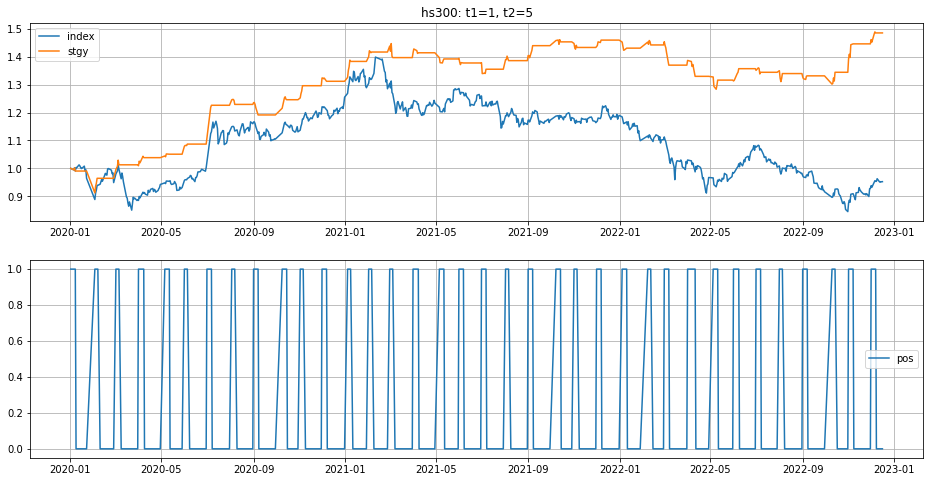

In [6]:
# 标的指数：'hs300' or 'csi500' or 'csi1000'

calendar_strategy(index_data, index_ids[0], start_date, end_date, day_range, fee_rate_stock)


读懂回测结果：

- AnnRet 表示年化收益，AnnVol 表示年化波动率，SR 表示夏普率，MaxDD 表示最大回撤，Calmar 表示年化收益与最大回撤的比值；
- 蓝色线 asset 代表投资标的，橙色线 stgy 代表策略，pos 代表仓位。

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.042582  0.210388  0.202395 -0.315704  0.134878  0.131701
stgy   0.177352  0.109059  1.626196 -0.106446  1.666128  0.623211


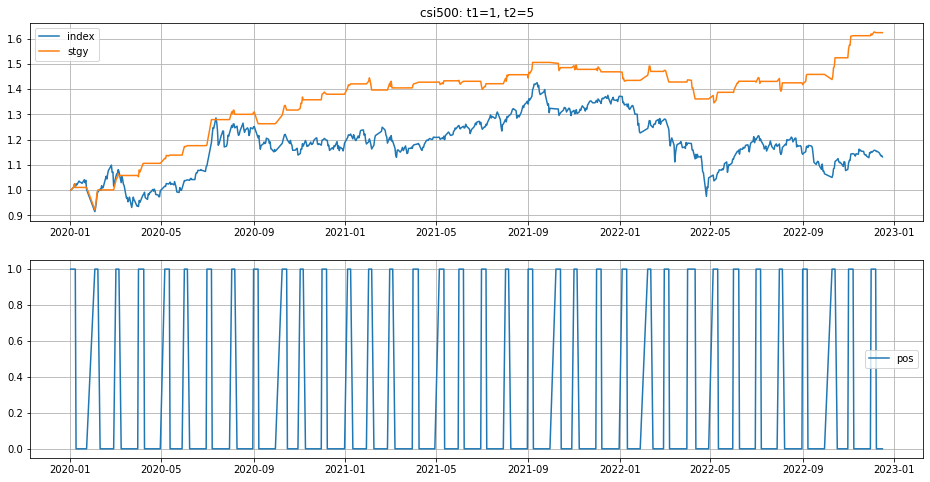

In [7]:
calendar_strategy(index_data, index_ids[1], start_date, end_date, day_range, fee_rate_stock)

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.047768  0.237842  0.200839 -0.346243  0.137961  0.148485
stgy   0.167123  0.121816  1.371925 -0.171917  0.972111  0.581724


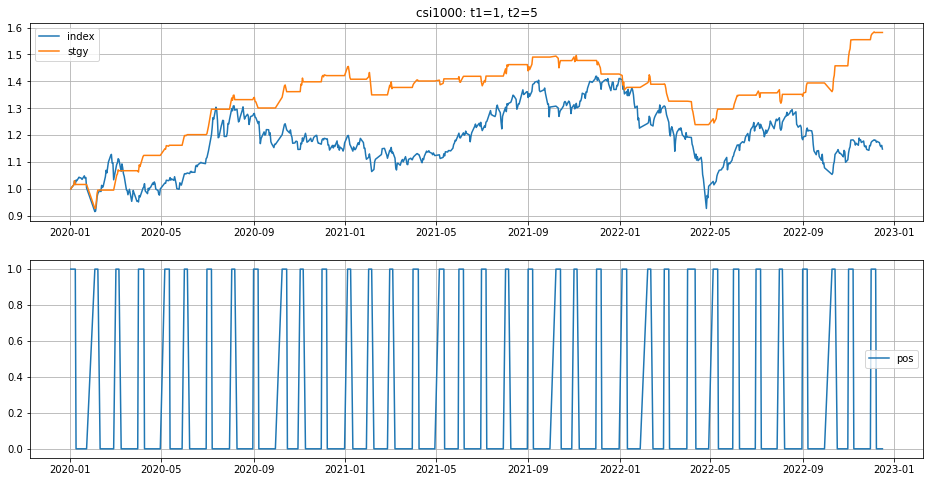

In [8]:
calendar_strategy(index_data, index_ids[2], start_date, end_date, day_range, fee_rate_stock)

## 使用基金替代指数

In [9]:
# 161017, 160119
symbol_id = '160119'
index_data = pd.read_csv(f'res/{symbol_id}.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]
index_data.rename(columns={'nav': symbol_id}, inplace=True)


         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.060683  0.188977  0.321112 -0.287292  0.211224  0.190997
stgy   0.144641  0.097399  1.485043 -0.104109  1.389329  0.493030


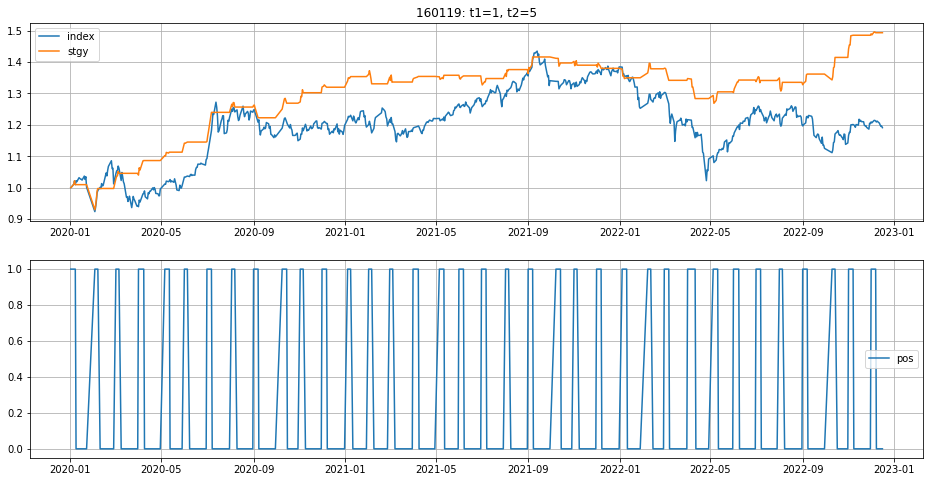

In [10]:
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_fund)

## 使用 ETF 替代指数

In [11]:
symbol_id = '510500'
index_data = pd.read_csv(f'res/{symbol_id}.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]
index_data.rename(columns={'nav': symbol_id}, inplace=True)


         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.063598   0.21032  0.302388 -0.315079  0.201848  0.200736
stgy   0.182206  0.109531  1.663501 -0.105243  1.731287  0.643145


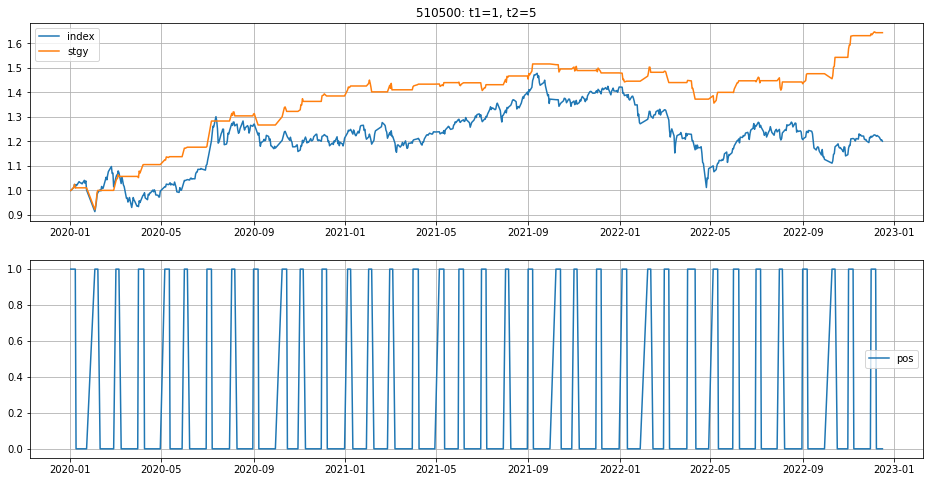

In [12]:
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)